In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import scipy
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import chisquare
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')
from datetime import datetime, timezone
import seaborn as sns
import statsmodels.stats.multitest as smstats
print (statsmodels.__version__)

0.13.5


In [34]:
settime = datetime(2023, 9, 19, 4, 0, 0, 0, tzinfo=timezone.utc)
df_ids_pred_met = pd.read_csv(r"C:\Users\clare.gamlin\Documents\CG_EM_paper\Prediction_csvs\Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius.csv")[['id', 'predicted_MET-type Label']]


cur_ssts = client.materialize.query_table( 'gamlin_2023_mcs', timestamp=settime)
# print (cur_ssts)
cur_ssts_pred = pd.merge(df_ids_pred_met, cur_ssts, left_on = 'id', right_on = 'pt_root_id')
print (cur_ssts_pred)

pre_id_mc = cur_ssts_pred["pt_root_id"]
# print (pre_id_mc)


                  id_x predicted_MET-type Label  id_ref  \
0   864691135013417622                Sst-MET-4  398518   
1   864691135118298333                Sst-MET-4  400905   
2   864691135341516741                Sst-MET-9  404260   
3   864691135404765166                Sst-MET-6  269585   
4   864691135544588584                Sst-MET-8  161736   
5   864691135572082925                Sst-MET-8  303085   
6   864691135577202181                Sst-MET-4  229767   
7   864691135697251738                Sst-MET-6  269414   
8   864691135699487522                Sst-MET-8  399458   
9   864691135785592004                Sst-MET-4  164494   
10  864691135969447781                Sst-MET-4  264932   
11  864691136116457636                Sst-MET-6  404262   
12  864691136118647832                Sst-MET-4  368160   
13  864691136195284556                Sst-MET-5  269485   
14  864691136238652476                Sst-MET-6  269334   
15  864691136618564493                Sst-MET-6  340252 

In [35]:
df2 = client.materialize.synapse_query(pre_ids= pre_id_mc, timestamp = settime)
print (df2.head())
md3 = client.materialize.query_table('aibs_metamodel_celltypes_v661', timestamp = settime)

soma_counts = md3['pt_root_id'].value_counts().rename_axis('pt_root_id').reset_index(name ='no_of_somas')
singlesomas = soma_counts.loc[soma_counts['no_of_somas'] == 1]
single_soma_merge = pd.merge(md3, singlesomas, left_on = 'pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas = pd.merge(df2, single_soma_merge, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('OPC','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('astrocyte','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('oligo','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('microglia','Glia')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('pericyte','Glia')
dfm_somas = dfm_somas.loc[(dfm_somas['cell_type'] != 'Glia')]


          id                          created  superceded_id valid  size  \
0  264572965 2020-11-04 06:48:59.403833+00:00            NaN     t  3596   
1  245036545 2020-11-04 06:48:59.510128+00:00            NaN     t   984   
2  133045371 2020-11-04 06:48:59.403833+00:00            NaN     t  9904   
3  246988768 2020-11-04 06:48:59.403833+00:00            NaN     t  3068   
4  253851535 2020-11-04 06:48:59.403833+00:00            NaN     t   868   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     97822862597478511  864691135118298333      97822862597469092   
1     96136418791314007  864691135699487522      96206787535493271   
2     86918869083617348  864691135969447781      86989237827805222   
3     96273444488363035  864691135118298333      96273444488364578   
4     97049562325379522  864691135013417622      97049562325377238   

      post_pt_root_id          pre_pt_position         post_pt_position  \
0  864691135990845374  [240310, 137786, 17382] 

In [36]:
all_somas = client.materialize.query_table('nucleus_neuron_svm', timestamp = settime)
print (all_somas.head())
print (all_somas.shape)
all_neurons = all_somas.loc[all_somas['cell_type'] == 'neuron']
print (all_neurons.head())
print (all_neurons.shape)

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


       id                          created  superceded_id valid  \
0  348209 2020-11-12 22:44:12.000600+00:00            NaN     t   
1  640071 2020-11-12 22:44:12.001636+00:00            NaN     t   
2  462557 2020-11-12 22:44:12.002734+00:00            NaN     t   
3  266849 2020-11-12 22:44:12.003774+00:00            NaN     t   
4  219514 2020-11-12 22:44:12.004784+00:00            NaN     t   

  classification_system   cell_type    pt_supervoxel_id          pt_root_id  \
0             is_neuron  not-neuron   92423916840203243  864691134945836023   
1             is_neuron  not-neuron                   0                   0   
2             is_neuron  not-neuron  101417167182010351  864691135294515893   
3             is_neuron  not-neuron   88330641678196634  864691136619535757   
4             is_neuron  not-neuron   85994867133853165  864691135644554735   

               pt_position  
0  [200928, 282512, 16717]  
1   [371696, 98672, 19791]  
2  [266304, 178832, 25200]  
3  [17

In [37]:
multisomas = soma_counts.loc[soma_counts['no_of_somas'] != 1]
multi_soma_merge = pd.merge(md3, multisomas, left_on = 'pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_multisomas = pd.merge(df2, multi_soma_merge, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')

C:\Users\clare.gamlin\AppData\Local\Temp\ipykernel_32668\882198400.py:122: RuntimeWarning: invalid value encountered in divide
  prob_np = np.divide(histtarget, histtotal)


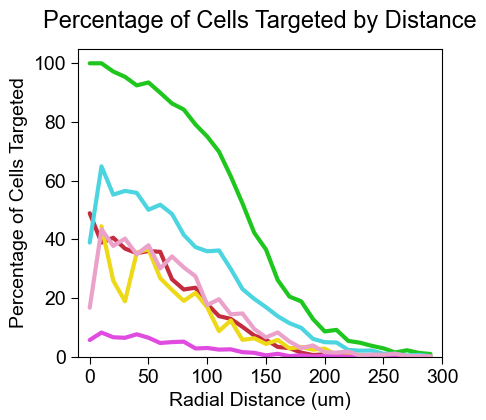

In [48]:
###MET avg histo target vs non-target across all predicted target cell types
### first column
binmin = 0
binmax = 310
binstep = 10
plt.rcParams["figure.figsize"] = (4.7,4)

###get IDs for each predicted MET-type
met8_pred = cur_ssts_pred.loc[cur_ssts_pred['predicted_MET-type Label'] == "Sst-MET-8"]
met8_id = met8_pred["pt_root_id"]

met4_pred = cur_ssts_pred.loc[cur_ssts_pred['predicted_MET-type Label'] == "Sst-MET-4"]
met4_id = met4_pred["pt_root_id"]

met6_pred = cur_ssts_pred.loc[cur_ssts_pred['predicted_MET-type Label'] == "Sst-MET-6"]
met6_id = met6_pred["pt_root_id"]

avg_prob_type_full = np.zeros(30, int)

fig, ax = plt.subplots()
###change metid to plot for each predicted met-type
metid = met8_id
cell_t_list = ['23P', '4P', '5P-IT', '5P-ET', '6P', 'INH']
for k in cell_t_list:
#     print (k)
#     new_non= np.zeros(49, int)
#     new_total = np.zeros(49, int)
#     new_target= np.zeros(49, int)
#     new_prob = np.zeros(49, int)
#     zeros = np.zeros(49, int)
    new_non= np.zeros(30, int)
    new_total = np.zeros(30, int)
    new_target= np.zeros(30, int)
    new_prob = np.zeros(30, int)
    zeros = np.zeros(30, int)
    for i in metid:
#         print (i)
        single_cell = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i].copy()
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('BC','INH')
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('MC','INH')
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('NGC','INH')
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('BPC','INH')
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('6P-CT','6P')
        single_cell['cell_type'] = single_cell['cell_type'].str.replace('6P-IT','6P')
    ###selelct single cell target type
        single_cell = single_cell.loc[single_cell['cell_type'] == k].copy()
        single_cell_sub = single_cell[["pre_pt_root_id","post_pt_root_id", "cell_type", "no_of_somas"]]
        single_cell_sub = single_cell_sub.drop_duplicates()
    ### get soma location of presynaptic cells
        pre_location = md3.loc[md3['pt_root_id'] == i].copy()
        pre_location = pre_location[["pt_root_id", "pt_position"]]
        pre_location = pre_location.rename(columns = {"pt_position": "pre_pt_position"})
#         print (pre_location.head())
    ### get soma location of all target cells
        post_soma = single_cell[["post_pt_root_id", "pt_position"]]
        post_soma = post_soma.rename(columns = {'pt_position': 'post_pt_position'})
        post_soma = post_soma.drop_duplicates(subset = 'post_pt_root_id')
        post_soma = post_soma.assign(pre_pt_root_id = i)

        converge_pre_post = pd.merge(pre_location, post_soma, left_on = 'pt_root_id', right_on = 'pre_pt_root_id', how = 'outer')

    #         ###convert presynaptic and postsynaptic soma coordinates from pixel to um space
        converge_pre_post['pre_x'] = converge_pre_post['pre_pt_position'].map(lambda x: x[0])
        converge_pre_post['pre_x'] = converge_pre_post['pre_x']*.004
        converge_pre_post['pre_y'] = converge_pre_post['pre_pt_position'].map(lambda x: x[1])
        converge_pre_post['pre_y'] = converge_pre_post['pre_y']*.004
        converge_pre_post['pre_z'] = converge_pre_post['pre_pt_position'].map(lambda x: x[2])
        converge_pre_post['pre_z'] = converge_pre_post['pre_z']*.04
        converge_pre_post['post_x'] = converge_pre_post['post_pt_position'].map(lambda x: x[0])
        converge_pre_post['post_x'] = converge_pre_post['post_x']*.004
        converge_pre_post['post_y'] = converge_pre_post['post_pt_position'].map(lambda x: x[1])
        converge_pre_post['post_y'] = converge_pre_post['post_y']*.004
        converge_pre_post['post_z'] = converge_pre_post['post_pt_position'].map(lambda x: x[2])
        converge_pre_post['post_z'] = converge_pre_post['post_z']*.04

        ##calc various distance metrics between somas
        converge_pre_post['distance'] = np.sqrt((converge_pre_post['pre_x']-converge_pre_post['post_x'])**2 + (converge_pre_post['pre_y']-converge_pre_post['post_y'])**2 + (converge_pre_post['pre_z']-converge_pre_post['post_z'])**2)
        converge_pre_post['y_offset'] = np.absolute((converge_pre_post['pre_y']-converge_pre_post['post_y']))
        converge_pre_post['xz_radius'] = np.sqrt((converge_pre_post['pre_x']-converge_pre_post['post_x'])**2 + (converge_pre_post['pre_z']-converge_pre_post['post_z'])**2)
        converge_pre_post['z_offset'] = np.asarray((converge_pre_post['pre_z']-converge_pre_post['post_z']))

        soma_x = converge_pre_post['pre_x'].max()
        soma_y = converge_pre_post['pre_y'].max()
        soma_z = converge_pre_post['pre_z'].max()

    #         ####find soma locations for all neurons in the dataset
        md3['cell_type'] = md3['cell_type'].str.replace('BC','INH').copy()
        md3['cell_type'] = md3['cell_type'].str.replace('MC','INH')
        md3['cell_type'] = md3['cell_type'].str.replace('NGC','INH')
        md3['cell_type'] = md3['cell_type'].str.replace('BPC','INH')
        md3['cell_type'] = md3['cell_type'].str.replace('6P-CT','6P')
        md3['cell_type'] = md3['cell_type'].str.replace('6P-IT','6P')
#         md3['cell_type'] = md3['cell_type'].str.replace('5P-PT','5P-ET')
        md3_onlyk = md3.loc[md3['cell_type'] == k].copy()

        md3_onlyk['pre_x'] = md3_onlyk['pt_position'].map(lambda x: x[0])
        md3_onlyk['pre_x'] = md3_onlyk['pre_x']*.004
        md3_onlyk['pre_y'] = md3_onlyk['pt_position'].map(lambda x: x[1])
        md3_onlyk['pre_y'] = md3_onlyk['pre_y']*.004
        md3_onlyk['pre_z'] = md3_onlyk['pt_position'].map(lambda x: x[2])
        md3_onlyk['pre_z'] = md3_onlyk['pre_z']*.04
        md3_onlyk['i_soma_x'] = soma_x
        md3_onlyk['i_soma_y'] = soma_y
        md3_onlyk['i_soma_z'] = soma_z
        md3_onlyk['counts'] = 0
        md3_onlyk['distance'] = np.sqrt((md3_onlyk['i_soma_x']-md3_onlyk['pre_x'])**2 + (md3_onlyk['i_soma_y']-md3_onlyk['pre_y'])**2 + (md3_onlyk['i_soma_z']-md3_onlyk['pre_z'])**2)
        md3_onlyk['y_offset'] = np.absolute((md3_onlyk['i_soma_y']-md3_onlyk['pre_y']))
        md3_onlyk['xz_radius'] = np.sqrt((md3_onlyk['i_soma_x']-md3_onlyk['pre_x'])**2 + (md3_onlyk['i_soma_z']-md3_onlyk['pre_z'])**2)
        md3_onlyk['z_offset'] = np.asarray((md3_onlyk['i_soma_z']-md3_onlyk['pre_z']))
        md3_onlyk = md3_onlyk.sort_values('distance', ascending = False)


    #         ####binning distance for histogram in 1D
        all_np = md3_onlyk['xz_radius'].to_numpy()
        target_np = converge_pre_post['xz_radius'].to_numpy()
        historange2 = np.arange(binmin,binmax,binstep)

        histtarget, bins4 = np.histogram(target_np, bins = historange2)
#         print (histtarget)
        histtotal, bins = np.histogram(all_np, bins = historange2)
#         print (histtotal)
        prob_np = np.divide(histtarget, histtotal)
        new_prob = np.vstack((prob_np, new_prob))

    no_of_ids = (len(metid))
    new_prob = np.delete(new_prob, no_of_ids, 0)

    ### calc avg hist

    avg_prob = np.mean(new_prob, axis = 0)
    avg_per = avg_prob*100

#     avg_prob_type = np.append(k, avg_prob)
    avg_prob_type_full = np.vstack((avg_prob_type_full, avg_prob))

    
    if k == '23P':
        linec = '#C42C3E'
    elif k == '4P':
        linec = '#1EC61E'
    elif k == '5P-IT':
        linec = '#4CD5E0'
    elif k == '5P-ET':
        linec = '#EDD918'
    elif k == '6P':
        linec = '#E04CE0'
    elif k == 'INH':
        linec = '#EAA2CB'
    with plt.style.context('seaborn-white', after_reset = True):
        afont = {'fontname':'Arial'}
       
        ax.plot(bins[:-1], avg_per, label = k, c = linec, linewidth = 3)
        plt.title('Percentage of Cells Targeted by Distance', fontsize = 17, **afont, pad = 15)
        ax.set_xlabel('Radial Distance (um)', fontsize = 14, **afont)
        ax.set_ylabel('Percentage of Cells Targeted', fontsize = 14, **afont)

        ax.set_ylim(ymin=0.0, ymax=105)
        ax.set_xlim(xmin = -10, xmax = 300)
        plt.tick_params(axis='both', length = 5)
        plt.xticks (fontsize = 14, **afont, visible = True)
        plt.yticks (fontsize = 14, **afont)

plt.savefig('met8_allfeatsnoradius_avg_10um_hist310_muted_celltype_xz_aibs_metamodel_celltypes_v661_q091923_090724.pdf', bbox_inches = 'tight', facecolor = 'white')
avg_prob_type_full = np.delete(avg_prob_type_full, 0, 0)


In [42]:
### [0:'23P', 1:'4P', 2:'5P-IT', 3:'5P-ET', 4:'6P', 5:'INH']
p01 = stats.kstest(avg_prob_type_full[0], avg_prob_type_full[1])[1]
p02 = stats.kstest(avg_prob_type_full[0], avg_prob_type_full[2])[1]
p03 = stats.kstest(avg_prob_type_full[0], avg_prob_type_full[3])[1]
p04 = stats.kstest(avg_prob_type_full[0], avg_prob_type_full[4])[1]
p05 = stats.kstest(avg_prob_type_full[0], avg_prob_type_full[5])[1]
p12 = stats.kstest(avg_prob_type_full[1], avg_prob_type_full[2])[1]
p13 = stats.kstest(avg_prob_type_full[1], avg_prob_type_full[3])[1]
p14 = stats.kstest(avg_prob_type_full[1], avg_prob_type_full[4])[1]
p15 = stats.kstest(avg_prob_type_full[1], avg_prob_type_full[5])[1]
p23 = stats.kstest(avg_prob_type_full[2], avg_prob_type_full[3])[1]
p24 = stats.kstest(avg_prob_type_full[2], avg_prob_type_full[4])[1]
p25 = stats.kstest(avg_prob_type_full[2], avg_prob_type_full[5])[1]
p34 = stats.kstest(avg_prob_type_full[3], avg_prob_type_full[4])[1]
p35 = stats.kstest(avg_prob_type_full[3], avg_prob_type_full[5])[1]
p45 = stats.kstest(avg_prob_type_full[4], avg_prob_type_full[5])[1]
pvalue = [p01, p02, p03, p04, p05, p12, p13, p14, p15, p23, p24, p25, p34, p35, p45]
print (pvalue)
smstats.fdrcorrection(pvalue, alpha=0.01, method='indep', is_sorted=False)

[0.0025300622362698397, 0.23907300248018645, 0.9578462903438838, 0.0025300622362698397, 0.8079631540901643, 0.015643390496754332, 0.006548396368058784, 4.326943555111202e-08, 0.0025300622362698397, 0.13500350250095441, 5.795481973815609e-06, 0.23907300248018645, 0.006548396368058784, 0.8079631540901643, 0.0002933405491362055]


(array([ True, False, False,  True, False, False, False,  True,  True,
        False,  True, False, False, False,  True]),
 array([6.32515559e-03, 2.98841253e-01, 9.57846290e-01, 6.32515559e-03,
        8.65674808e-01, 2.60723175e-02, 1.22782432e-02, 6.49041533e-07,
        6.32515559e-03, 2.02505254e-01, 4.34661148e-05, 2.98841253e-01,
        1.22782432e-02, 8.65674808e-01, 1.46670275e-03]))

In [199]:
pois_df = pd.DataFrame({'cell_id' : [], 'cell_type': [], 'pvalue': []})


In [203]:
### Poisson analysis (run for met-8, met-4, and met-6)
from matplotlib import figure
afont = {'fontname':'Arial'}
met_id = met6_id
###change isin filter list (from options above (met8_id; met4_id; met6_id))
single_cell = dfm_somas.loc[dfm_somas['pre_pt_root_id'].isin(met_id)]
single_cell_sub = single_cell[["pre_pt_root_id","post_pt_root_id", "cell_type", "no_of_somas"]].copy()

single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('BC','INH')
single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('MC','INH')
single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('NGC','INH')
single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('BPC','INH')
single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('6P-CT','6P')
single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('6P-IT','6P')

##count the number of times the presynaptic cell synapses onto a given postsynaptic cell id
converge_test = single_cell_sub.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type']).size().reset_index(name ='convergent_synapses')

###remove duplicate ids so we only have a single entry for every target cell & sort in descending order
converge_call = converge_test.drop_duplicates()
sorted_converge = converge_test.sort_values(["convergent_synapses"], ascending = False)
# print (sorted_converge.head(20))

##count the number of somas that receive single/double/triple synapses from presynaptic cell onto a given cell type 
converge_group = converge_call.groupby(['pre_pt_root_id','cell_type', 'convergent_synapses'], as_index = False).size()
print (converge_group.head(5))

## sum the total number of synapses onto a given cell type
converge_sum_syn = converge_call.groupby(['pre_pt_root_id','cell_type'], as_index = False).sum()
# print (converge_sum_syn.head(20))

##sum the total number of somas of a given cell type targeted  = "no_of_somas", here "convegent_synapses" = sum across cell(# of syn * # of somas)
converge_sum = converge_call.groupby(['pre_pt_root_id','cell_type'], as_index = False).size()
# print (converge_sum.head())

## merge df so every pre-syn cell + cell type + # of convergent syn can be divided by total number of target cells
converge_gr_sum_syn = pd.merge (converge_sum_syn, converge_sum, left_on = ['pre_pt_root_id', 'cell_type'], right_on = ['pre_pt_root_id', 'cell_type'], how = 'outer')
converge_gr_sum_syn_sub = converge_gr_sum_syn[['pre_pt_root_id', 'cell_type', 'convergent_synapses', 'size']]
converge_gr_sum_syn_sub['mean_syn'] = converge_gr_sum_syn_sub['convergent_synapses']/converge_gr_sum_syn_sub['size']
# print (converge_gr_sum_syn_sub.head(5))

## take mean of mean number of synapses from presynaptic cell onto target cell class
mean_syn_cell_class = converge_gr_sum_syn_sub.groupby(['cell_type']).mean()
# print(mean_syn_cell_class.head(7))



### merge df so every pre-syn cell + cell type + # of convergent syn can be divided by total number of L23 targets (for example)
converge_gr_sum = pd.merge (converge_group, converge_sum, left_on = ['pre_pt_root_id', 'cell_type'], right_on = ['pre_pt_root_id', 'cell_type'], how = 'outer')


### here no_of_somas_x = number of L23/L4 targets that receive 1/2/3/4 syn, no_of_somas_y = total number of L23/L4/L5 IT targets
converge_gr_sum_sub = converge_gr_sum[["pre_pt_root_id","cell_type", "convergent_synapses", "size_x", "size_y"]]
converge_gr_sum_sub['percent'] = (converge_gr_sum_sub['size_x']/converge_gr_sum_sub['size_y'])*100


for i in met_id:
    print (i)
    justi = converge_gr_sum_syn_sub.loc[converge_gr_sum_syn_sub['pre_pt_root_id'] == i].copy()
    giveni = converge_group.loc[converge_group['pre_pt_root_id']==i].copy()
    for j in cell_t_list:
        print (j)
        justj = justi.loc[justi['cell_type'] == j].copy()
        mean_syn = justj['mean_syn'].copy()
        mean_syn = mean_syn.values[0]
        num_connect = justj['size'].copy()
        num_connect = num_connect.values[0]
        givenij = giveni.loc[giveni['cell_type'] == j].copy()
#         print (givenij.head())
        lamda = mean_syn-1
        np_conv_syn_o = givenij['convergent_synapses'].to_numpy()
        max_conv = (np.max(np_conv_syn_o)+1)
#         print (max_conv)
        ideal_array = np.arange(1, (max_conv),1)
#         print (ideal_array)
#         print (np_conv_syn_o)
        tfisin = np.isin(ideal_array, np_conv_syn_o)
        index_false = np.where(tfisin == False)
        index_false1 = np.add(index_false,1)
        print (index_false1)
        for f in np.nditer(index_false1, flags = ['zerosize_ok']):
            data = pd.DataFrame([[i, j, f, 0]], columns=list(['pre_pt_root_id', 'cell_type','convergent_synapses', 'size']))
            givenij = pd.concat([givenij, data])
        givenij_sorted = givenij.sort_values(by=['convergent_synapses'])
        givenij_sorted['convergent_synapses']= pd.to_numeric(givenij_sorted['convergent_synapses'])
        givenij_sorted['lamda'] = lamda
        givenij_sorted['num_connections'] = num_connect
        givenij_sorted['Poisson_prob'] = poisson.pmf((givenij_sorted['convergent_synapses']-1), givenij_sorted['lamda'])
        givenij_sorted['Poisson_dist'] = givenij_sorted['Poisson_prob']*givenij_sorted['num_connections']

        np_syn = givenij_sorted['size'].to_numpy()

        np_poiss = givenij_sorted['Poisson_dist'].to_numpy()

        diff_poiss = (np_syn.sum())-(np_poiss.sum())

        np_conv_syn_o = givenij_sorted['convergent_synapses'].to_numpy()

        if max_conv < 17:
            df_app = pd.DataFrame([[i, j, max_conv, 0, lamda, num_connect,(1-poisson.cdf(max_conv, lamda)), diff_poiss ]], columns=list(['pre_pt_root_id', 'cell_type','convergent_synapses', 'size', 'lamda', 'num_connections', 'Poisson_prob', 'Poisson_dist']))
            givenij_concat = pd.concat([givenij_sorted, df_app])
        else: 
            givenij_concat = givenij_sorted
        
        np_syn_concat = givenij_concat['size'].to_numpy()
        np_poiss_concat = givenij_concat['Poisson_dist'].to_numpy()
        np_conv_syn = givenij_concat['convergent_synapses'].to_numpy()
        pvalue = chisquare(np_syn_concat, np_poiss_concat, ddof=0, axis=0).pvalue
#         print ("pvalue")
#         print (pvalue)
        data_poiss = {'cell_id' : [str(i)], 'cell_type': [j], 'pvalue': [pvalue]}
        pois_row = pd.DataFrame(data = data_poiss)
        print (pois_row)
        pois_df = pd.concat([pois_df, pois_row])
# # mu = 1
# # mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
# # fig, ax = plt.subplots(1, 1)
# # pois_dist = np.arange(poisson.ppf(0.01, mu),poisson.ppf(0.99, mu))
# # print(pois_dist)
# # ax.plot(pois_dist, poisson.pmf(pois_dist, mu), 'bo', ms=8, label='poisson pmf')
# # ax.vlines(pois_dist, 0, poisson.pmf(pois_dist, mu), colors='b', lw=5, alpha=0.5)
# # plt.show()

# # poisson_value1 = stats.poisson.pmf(2, mu)
# # print (poisson_value1)

pois_pivot = pois_df.pivot(index = ['cell_id'], columns = ['cell_type'])
print (pois_pivot.head())


       pre_pt_root_id cell_type  convergent_synapses  size
0  864691135404765166       23P                    1   273
1  864691135404765166       23P                    2    49
2  864691135404765166       23P                    3    14
3  864691135404765166       23P                    4     5
4  864691135404765166       23P                    5     4
864691135404765166
23P
[]
              cell_id cell_type        pvalue
0  864691135404765166       23P  7.678150e-36
4P
[]
              cell_id cell_type    pvalue
0  864691135404765166        4P  0.140597
5P-IT
[[4 6 7 9]]
              cell_id cell_type  pvalue
0  864691135404765166     5P-IT     0.0
5P-ET
[[12 14 15 16 17 18 19]]
              cell_id cell_type  pvalue
0  864691135404765166     5P-ET     0.0
6P
[[5]]
              cell_id cell_type         pvalue
0  864691135404765166        6P  2.691786e-112
INH
[[ 5  6  7  8  9 10 11 12]]
              cell_id cell_type  pvalue
0  864691135404765166       INH     0.0
86469113569725

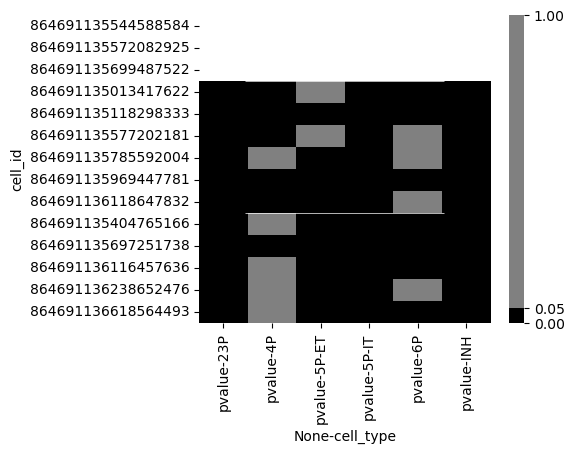

In [204]:
cell_id_order = ['864691135544588584', '864691135572082925', '864691135699487522', '864691135013417622', '864691135118298333', '864691135577202181', '864691135785592004', '864691135969447781', '864691136118647832', '864691135404765166', '864691135697251738', '864691136116457636', '864691136238652476', '864691136618564493']
pois_pivot_sorta = pois_pivot.reindex(index = cell_id_order)

cmap1 = (matplotlib.colors.ListedColormap(['black', 'grey']))
bounds = [0, 0.05, 1]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)
heat = sns.heatmap(pois_pivot_sorta, cmap = cmap1, norm = norm, cbar_kws ={'spacing': 'proportional'})
heat.hlines([3, 9], *ax.get_xlim(), color = 'white', linewidth = 0.5)
# plt.savefig('heatmap_Poiss.pdf', bbox_inches = 'tight')

       pre_pt_root_id cell_type  convergent_synapses  size_x  size_y  \
0  864691135404765166       23P                    1     273     345   
1  864691135404765166       23P                    2      49     345   
2  864691135404765166       23P                    3      14     345   
3  864691135404765166       23P                    4       5     345   
4  864691135404765166       23P                    5       4     345   

     percent  
0  79.130435  
1  14.202899  
2   4.057971  
3   1.449275  
4   1.159420  
  cell_type  convergent_synapses  pre_pt_root_id  size_x  size_y    percent  \
0       23P                    1    8.646911e+17  329.60   413.0  79.858808   
1       23P                    2    8.646911e+17   60.80   413.0  14.707779   
2       23P                    3    8.646911e+17   15.00   413.0   3.555277   
3       23P                    4    8.646911e+17    5.40   413.0   1.322293   
4       23P                    5    8.646911e+17    2.25   405.5   0.566306   

  

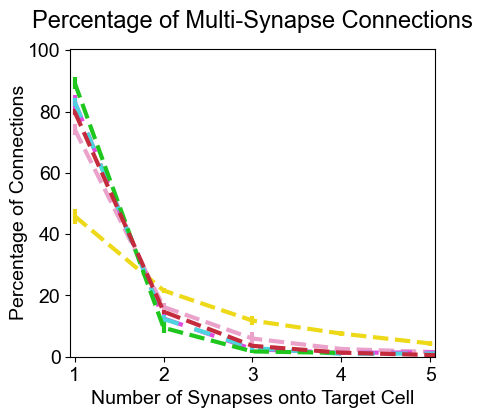

In [205]:
##create plots looking at multi-synaptic connetions
#Average % of somas that are single/double by cell type: here "convergent_synapses_x" = single syn connections/doubles/triples, etc
print (converge_gr_sum_sub.head())
converge_gr_sum_mean = converge_gr_sum_sub.groupby(['cell_type', 'convergent_synapses'], as_index = False).mean()
converge_gr_sum_sem  = converge_gr_sum_sub.groupby(['cell_type', 'convergent_synapses'], as_index = False).sem()
converge_gr_sum_mean['sem'] = converge_gr_sum_sem['percent']
print (converge_gr_sum_mean.head())

# converge_gr_sum_mean =converge_gr_sum_mean*100
# converge_gr_sum_mean_sub = converge_gr_sum_mean[['percent', 'sem']]

converge_gr_sum_mean23 = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == '23P']
converge_gr_sum_mean4 = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == '4P']
converge_gr_sum_meanit = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == '5P-IT']
converge_gr_sum_meanpt = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == '5P-ET']
converge_gr_sum_mean6 = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == '6P']
converge_gr_sum_meaninh = converge_gr_sum_mean.loc[converge_gr_sum_mean['cell_type'] == 'INH']
print (converge_gr_sum_meaninh.head())
print (converge_gr_sum_mean4.head())
print (converge_gr_sum_meanit.head())


ax = converge_gr_sum_meaninh.plot (x = 'convergent_synapses',y = 'percent', color = "#EAA2CB", yerr = 'sem', label = 'INH', linewidth =3, linestyle='dashed')
converge_gr_sum_mean6.plot (x = 'convergent_synapses',y = 'percent', ax = ax, color = "#E04CE0", yerr = 'sem', label = 'L6', linewidth = 3, linestyle='dashed', dashes = (5,3))
converge_gr_sum_meanpt.plot (x = 'convergent_synapses',y = 'percent', ax = ax, color = "#EDD918", yerr = 'sem', label = 'L5-ET', linewidth = 3, linestyle='dashed')
converge_gr_sum_meanit.plot (x = 'convergent_synapses',y = 'percent', ax = ax, color = "#4CD5E0", yerr = 'sem', label = 'L5-IT', linewidth = 3, linestyle='dashed', dashes = (4, 4))
converge_gr_sum_mean4.plot (x = 'convergent_synapses',y = 'percent', ax = ax, color = "#1EC61E", yerr = 'sem', label = 'L4', linewidth = 3 , linestyle='dashed')
converge_gr_sum_mean23.plot (x = 'convergent_synapses', ax = ax, y = 'percent', color = "#C42C3E", yerr = 'sem', label = 'L2/3', linewidth = 3, linestyle='dashed')




# clarecolor = [ '#EAA2CB','#E04CE0', '#EDD918', '#4CD5E0', '#1EC61E', '#C42C3E']
# clareorder = ['INH', '6P', '5P-ET', '5P-IT', '4P', '23P' ]
# ax = sns.lineplot(data = converge_gr_sum_sub, x = 'convergent_synapses', y = 'percent', hue = 'cell_type', hue_order = clareorder, palette = clarecolor)

# ###non log line graphs
# plt.rcParams["figure.figsize"] = (4.7,4.4)
fig.set_figwidth(4.7)
fig.set_figheight(4.4)
plt.xlim(0.95,5.05)
plt.ylim(0.0,100.5)

plt.xticks ([1, 2, 3, 4, 5],fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.get_legend().remove()
plt.title('Percentage of Multi-Synapse Connections', fontsize = 17, **afont, pad = 15)
plt.xlabel ('Number of Synapses onto Target Cell', fontsize = 14, **afont)
plt.ylabel ('Percentage of Connections', fontsize = 14, labelpad = 0, **afont)
plt.savefig("Met6_syn_percent_aibs_metamodel_celltypes_v661_q091923_05_090524.pdf", bbox_inches = 'tight',facecolor = 'None')


              pt_root_id          pre_pt_position      pre_pt_root_id  \
0     864691135572082925  [188048, 199488, 21406]  864691135572082925   
5174  864691135572082925  [188048, 199488, 21406]  864691135572082925   
5175  864691135572082925  [188048, 199488, 21406]  864691135572082925   
5176  864691135572082925  [188048, 199488, 21406]  864691135572082925   
5180  864691135572082925  [188048, 199488, 21406]  864691135572082925   
...                  ...                      ...                 ...   
1395  864691135572082925  [188048, 199488, 21406]  864691135572082925   
1396  864691135572082925  [188048, 199488, 21406]  864691135572082925   
1397  864691135572082925  [188048, 199488, 21406]  864691135572082925   
1387  864691135572082925  [188048, 199488, 21406]  864691135572082925   
1378  864691135572082925  [188048, 199488, 21406]  864691135572082925   

         post_pt_root_id cell_type  no_of_somas  counts  \
0     864691135850827207       23P            1       1   
5174 

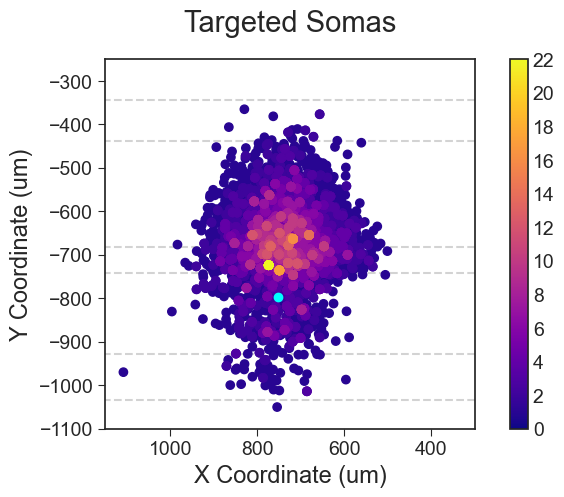

In [53]:
###column 3 - heatmap of target cells color-coded by # of synapes received, cyan soma of presynaptic cell
# example_cells = [864691135925834510, 864691136118647832,864691135988665856]
example_cells = [864691135572082925, 864691136118647832,864691136238652476]
example_cells = [864691135572082925]
for i in example_cells:
    single_cell = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i].copy()
    single_cell_sub = single_cell[["pre_pt_root_id","post_pt_root_id", "cell_type", "no_of_somas"]]

    converge = single_cell['post_pt_root_id'].value_counts().rename_axis('post_pt_root_id').reset_index(name ='counts')
    converge_call=pd.merge(single_cell_sub, converge, left_on = 'post_pt_root_id', right_on ='post_pt_root_id', how = 'outer')

    sorted_converge = converge_call.sort_values(["counts"], ascending = False)
    md3_sub = md3[["pt_root_id","pt_position", "cell_type"]]
    merge_targets = pd.merge(single_cell_sub, md3_sub, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'outer', indicator = True)
    
    non_target = merge_targets.loc[merge_targets['_merge'] == "right_only"]
    non_target_sub = non_target[["pt_root_id","pt_position"]].copy()

        
        ### get soma location of presynaptic cells
    pre_location = md3.loc[md3['pt_root_id'] == i]
    pre_location = pre_location[["pt_root_id", "pt_position"]]
    pre_location = pre_location.rename(columns = {"pt_position": "pre_pt_position"})
    converge_pre = pd.merge(pre_location, converge_call, left_on = 'pt_root_id', right_on = 'pre_pt_root_id', how = 'inner')


        ### get soma location of all target cells
    post_soma = single_cell[["post_pt_root_id", "pt_position"]]
    post_soma = post_soma.rename(columns = {'pt_position': 'post_pt_position'})
    post_soma = post_soma.drop_duplicates(subset = 'post_pt_root_id')
    converge_pre_post = pd.merge(converge_pre, post_soma, on = 'post_pt_root_id', how = 'inner')

    converge_pre_post['pre_x'] = converge_pre_post['pre_pt_position'].map(lambda x: x[0])
    converge_pre_post['pre_x'] = converge_pre_post['pre_x']*.004
    converge_pre_post['pre_y'] = converge_pre_post['pre_pt_position'].map(lambda x: x[1])
    converge_pre_post['pre_y'] = converge_pre_post['pre_y']*.004
    converge_pre_post['pre_z'] = converge_pre_post['pre_pt_position'].map(lambda x: x[2])
    converge_pre_post['pre_z'] = converge_pre_post['pre_z']*.04
    converge_pre_post['post_x'] = converge_pre_post['post_pt_position'].map(lambda x: x[0])
    converge_pre_post['post_x'] = converge_pre_post['post_x']*.004
    converge_pre_post['post_y'] = converge_pre_post['post_pt_position'].map(lambda x: x[1])
    converge_pre_post['post_y'] = converge_pre_post['post_y']*.004
    converge_pre_post['post_z'] = converge_pre_post['post_pt_position'].map(lambda x: x[2])
    converge_pre_post['post_z'] = converge_pre_post['post_z']*.04
    converge_pre_post['distance'] = np.sqrt((converge_pre_post['pre_x']-converge_pre_post['post_x'])**2 + (converge_pre_post['pre_y']-converge_pre_post['post_y'])**2 + (converge_pre_post['pre_z']-converge_pre_post['post_z'])**2)
    converge_pre_post['y_offset'] = np.absolute((converge_pre_post['pre_y']-converge_pre_post['post_y']))
    converge_pre_post["post_y"] = converge_pre_post["post_y"]*-1
    converge_pre_post["pre_y"] = converge_pre_post["pre_y"]*-1
    single_pre = converge_pre_post.iloc[[0]]
    
    soma_max = (single_pre['pre_z'].max())
    soma_plus = (soma_max + 10)
    soma_minus = (soma_max - 10) 

    xmax =(converge_pre_post['post_x'].max())
    xmin = (converge_pre_post['post_x'].min())

    ymax =(converge_pre_post['post_y'].max())
    ymin = (converge_pre_post['post_y'].min())

    zmax =(converge_pre_post['post_z'].max())
    zmin = (converge_pre_post['post_z'].min())

    non_target_sub['pre_x'] = non_target_sub['pt_position'].map(lambda x: x[0])
    non_target_sub['pre_x'] = non_target_sub['pre_x']*.004
    non_target_sub['pre_y'] = non_target_sub['pt_position'].map(lambda x: x[1])
    non_target_sub['pre_y'] = non_target_sub['pre_y']*.004
    non_target_sub['pre_z'] = non_target_sub['pt_position'].map(lambda x: x[2])
    non_target_sub['pre_z'] = non_target_sub['pre_z']*.04
    non_target_sub["pre_y"] = non_target_sub["pre_y"]*-1

    non_target_sub_sm = non_target_sub.loc[(non_target_sub['pre_x'] < xmax)]
    non_target_sub_sm = non_target_sub_sm.loc[(non_target_sub_sm['pre_x'] > xmin)]
    non_target_sub_sm = non_target_sub_sm.loc[(non_target_sub_sm['pre_y'] < ymax) & (non_target_sub_sm['pre_y'] > ymin)]
    non_target_sub_sm = non_target_sub_sm.loc[(non_target_sub_sm['pre_z'] < zmax) & (non_target_sub_sm['pre_z'] > zmin)]
    converge_pre_post_narrow = converge_pre_post.loc[(converge_pre_post['post_z'] < soma_plus) & (converge_pre_post['post_z'] > soma_minus)]
    converge_pre_post.sort_values('counts', ascending=True, inplace=True)
    
    print (converge_pre_post)
    print (converge_pre_post[['pre_pt_root_id', 'post_pt_root_id']].drop_duplicates())
    
    with plt.style.context('seaborn-white', after_reset = True):
        afont = {'fontname':'Arial'}
        ax = plt.figure().gca()  
#         #864691135572082925
        plt.hlines(-928, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
        plt.hlines(-1033, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
        plt.hlines(-344, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
        plt.hlines(-683, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
        plt.hlines(-741, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
        plt.hlines(-438, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         #864691136118647832
#         plt.hlines(-891, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-1009, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-322, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-658, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-715, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-403, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)        
        #864691136238652476
#         plt.hlines(-915, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-1022, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-349, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-663, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-710, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)
#         plt.hlines(-435, color = 'lightgrey', xmin = 300, xmax = 1350, linestyle = 'dashed', zorder = 0)        
        scatter = ax.scatter(converge_pre_post.post_x , converge_pre_post.post_y, c= converge_pre_post.counts,  cmap = 'plasma', vmin = 0, vmax = 22)

        ax.scatter(single_pre.pre_x, single_pre.pre_y, color='cyan')
        ax.set_aspect('equal')
#         ax.set_xlim(500, 1350)
        ax.set_xlim(300, 1150)
        ax.set_ylim(-1100, -250)
        ax.invert_xaxis()
        plt.tick_params(axis='both', length = 5)
        plt.xticks (fontsize = 14, **afont)
        plt.yticks (fontsize = 14, **afont)
        plt.xlabel('X Coordinate (um)', fontsize = 17, **afont)
        plt.ylabel('Y Coordinate (um)', fontsize = 17, **afont)
        plt.title('Targeted Somas', fontsize = 21, **afont, pad = 20)
        cb = plt.colorbar(scatter, ticks=[0,2, 4,6, 8,10, 12,14, 16,18, 20, 22], pad = 0.07, ax = ax)
        cb.ax.tick_params(labelsize = 14)
#         plt.savefig("X_Y_scatter_syn_num_title_flipx_same_cbar_eq_layeravgtop_{}_aibs_metamodel_celltypes_v661_q091923_090724.pdf".format(i), bbox_inches = 'tight')
        plt.show()

            



cell target type 4P
percent synapse both 0.0196078431372549
percent synapse basal only 0.6470588235294118
percent synapse apical only 0.3333333333333333
sum apical basal 1.0

cell target type 5P-IT
percent synapse both 0.12359550561797752
percent synapse basal only 0.8426966292134831
percent synapse apical only 0.033707865168539325
sum apical basal 0.9999999999999999

cell target type 23P
percent synapse both 0.002398081534772182
percent synapse basal only 0.10071942446043165
percent synapse apical only 0.8968824940047961
sum apical basal 1.0

cell target type INH
percent synapse both 0.17699115044247787
percent synapse basal only 0.7079646017699115
percent synapse apical only 0.11504424778761062
sum apical basal 1.0

cell target type 5P-ET
percent synapse both 0.31910569105691056
percent synapse basal only 0.6260162601626016
percent synapse apical only 0.054878048780487805
sum apical basal 1.0

cell target type 6P
percent synapse both 0.1111111111111111
percent synapse basal only 0.8

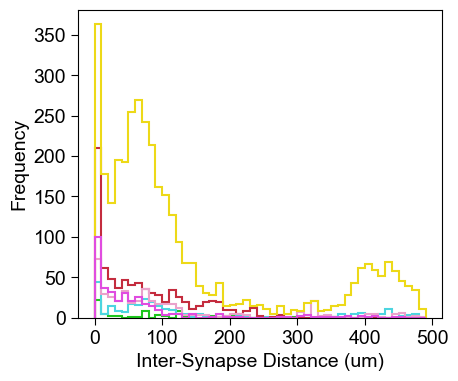

In [45]:
### fourth column -line plot showing number of synapses onto target cell
binmin = 0
binmax = 500
binstep = 10
hist_range = np.arange(binmin,binmax,binstep)
from matplotlib import figure
afont = {'fontname':'Arial'}
# plt.rcParams["figure.figsize"] = (4.5,4.2)
fig.set_figwidth(4.2)
fig.set_figheight(4.5)

met_id = met6_id

# cell_t_list = [ '23P',  '5P-ET','5P-IT', 'INH', '4P','6P'] #met4
# cell_t_list = [ '5P-ET', '23P', '6P', 'INH','5P-IT', '4P'] #met6
cell_t_list = [ '4P','5P-IT','23P', 'INH', '5P-ET', '6P'] #met8


for j in cell_t_list:
    all_syn_dist = []
    all_syn_y_dist = []
    syn_both = []
    syn_basal = []
    syn_apical = []
#     print (j)
    for i in met_id:
#         print (i)
        ###change isin filter list (from options above (met8_id; met4_id; met6_id))
        single_cell = dfm_somas.loc[dfm_somas['pre_pt_root_id']==i]
    #     print (single_cell.head())
        single_cell_sub = single_cell[["pre_pt_root_id","post_pt_root_id", "cell_type", "no_of_somas", "ctr_pt_position"]].copy()

        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('BC','INH')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('MC','INH')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('NGC','INH')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('BPC','INH')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('5P-PT','5P-ET')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('6P-CT','6P')
        single_cell_sub['cell_type'] = single_cell_sub['cell_type'].str.replace('6P-IT','6P')
        single_cell_sub = single_cell_sub.loc[single_cell_sub['cell_type'] == j].copy()
        ##count the number of times the presynaptic cell synapses onto a given postsynaptic cell id
        converge_test = single_cell_sub.groupby(['post_pt_root_id', 'cell_type']).size().reset_index(name ='convergent_synapses')

        converge_test_mult = converge_test.loc[converge_test['convergent_synapses'] > 1]
    #     print (converge_test_mult.head())
        for k in converge_test_mult['post_pt_root_id']:
    #         print (k)
            subset = single_cell_sub.loc[single_cell_sub['post_pt_root_id'] == k].copy()
            subset['pre_x_0'] = subset['ctr_pt_position'].map(lambda x: x[0])
            subset['pre_x'] = subset['pre_x_0']*.004
            subset['pre_y_0'] = subset['ctr_pt_position'].map(lambda x: x[1])
            subset['pre_y'] = subset['pre_y_0']*.004
            subset['pre_z_0'] = subset['ctr_pt_position'].map(lambda x: x[2])
            subset['pre_z'] = subset['pre_z_0']*.04
            
            ####find euclidean distance between synapses onto same target
            subset_coord = subset[['pre_x', 'pre_y', 'pre_z']]
            dist_mat = subset_coord.to_numpy()
            dm = pdist(dist_mat, 'euclidean')
            all_syn_dist = np.append(all_syn_dist , dm)

            ####find y distance between synapses onto same target (same as above just y coord)
            y_subset = subset[['pre_y']]
            dist_y = y_subset.to_numpy()
            dm_y = pdist(dist_y, 'euclidean')
            ### determine whether multi-synapses fall onto both apical and basal dendrites or only one location
            both = False
            basal = False
            apical = False
            for a in dm_y:
                if a > 300:
                    both = True
            if both == False:
                if np.mean(dist_y) > 535:
                    basal = True
                if np.mean(dist_y) < 535: ###535 = average middle y coordinate of L2/3 drawings from jsons
                    apical = True
            syn_both = np.append(syn_both, both)
            syn_basal = np.append(syn_basal, basal)
            syn_apical = np.append(syn_apical, apical)
            all_syn_y_dist = np.append(all_syn_y_dist, dm_y)


###calculate % of synapses onto apical vs basal dendrites
    print ("")
    print ('cell target type', j)
    per_syn_both = (np.sum(syn_both)/ len(syn_both))
    print ('percent synapse both', per_syn_both)
    per_syn_basal = (np.sum(syn_basal)/ len(syn_basal))
    print ('percent synapse basal only', per_syn_basal)
    per_syn_apical = (np.sum(syn_apical)/ len(syn_apical))
    print ('percent synapse apical only', per_syn_apical)
    print ('sum apical basal', (per_syn_apical + per_syn_basal + per_syn_both))
    

####plot histogram of inter-synapse distances
    if j == '5P-ET':
        linec = '#EDD918'
    elif j == '4P':
        linec = '#1EC61E'
    elif j == '5P-IT':
        linec = '#4CD5E0'
    elif j == '23P':
        linec = '#C42C3E'
    elif j == '6P':
        linec = '#E04CE0'
    elif j == 'INH':
        linec = '#EAA2CB'
#     if j == '23P':
#         linec = '#C42C3E'

    ax = plt.hist(all_syn_dist, hist_range, label = j,histtype='step', color = linec, linewidth = 1.5)
    fig.set_figwidth(4.7)
    fig.set_figheight(4.4)
    plt.tick_params(axis='both', length = 5)
    plt.xticks (fontsize = 14, **afont)
    plt.yticks (fontsize = 14, **afont)
    plt.xlabel('Inter-Synapse Distance (um)', fontsize = 14, **afont)
    plt.ylabel('Frequency', fontsize = 14, **afont)
#     plt.title('Synapse Locations onto a Single Target', fontsize = 21, **afont, pad = 20)

#     plt.savefig("Met8_intersyn_dist_per_target__aibs_metamodel_celltypes_v661_q091923_042824.pdf", bbox_inches = 'tight',facecolor = 'white')
    all_syn_dist = []
    all_syn_y_dist = []
    syn_both = []
    syn_basal = []
    syn_apical = []

